In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
path = '/content/drive/MyDrive/CECS 550/lfw'

In [16]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
device

device(type='cuda')

torch.Size([250, 250, 3])


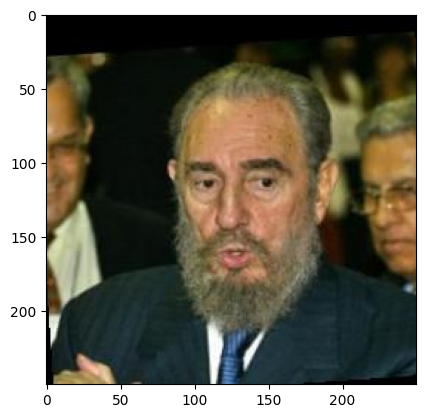

In [19]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [47]:
print("Dimension:", x.shape)

Dimension: torch.Size([250, 250, 3])


The 3 dimension represents,

Height x Width x Channels

x.shape[0] is height
x.shape[1] is width
x.shape[2] is number of channels which Red, Green, Blue in this case.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [20]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc_conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)

        self.dec_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_conv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_conv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

        self.adjust_size = nn.AdaptiveAvgPool2d((250, 250))

    def encoder(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = F.relu(self.enc_conv4(x))
        return x

    def decoder(self, x):
        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = F.relu(self.dec_conv3(x))
        x = torch.sigmoid(self.dec_conv4(x))
        x = self.adjust_size(x)
        return x

    def forward(self, x, add_noise=False, noise_factor=0.1):
        x = self.encoder(x)
        if add_noise:
            noise = torch.randn_like(x) * noise_factor
            x = x + noise
        x = self.decoder(x)
        return x

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [21]:
model = AE()

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [22]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [24]:
model.to(device)

for epoch in range(10):
    total_loss = 0
    for batch in dataloader:
        inputs = batch[0].to(device)

        optim.zero_grad()

        outputs = model(inputs)

        loss = loss_function(outputs, inputs)

        loss.backward()
        optim.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{10}], Loss: {average_loss:.4f}')

Epoch [1/10], Loss: 0.0144
Epoch [2/10], Loss: 0.0062
Epoch [3/10], Loss: 0.0049
Epoch [4/10], Loss: 0.0042
Epoch [5/10], Loss: 0.0037
Epoch [6/10], Loss: 0.0035
Epoch [7/10], Loss: 0.0033
Epoch [8/10], Loss: 0.0031
Epoch [9/10], Loss: 0.0030
Epoch [10/10], Loss: 0.0029


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

In [25]:
data = iter(dataloader)
images, _ = next(data)
random_index = torch.randint(len(images), size=(1,)).item()
original_img = images[random_index]

In [26]:
input_img = original_img.unsqueeze(0).to(device)

In [27]:
model.eval()
with torch.no_grad():
    reconstructed_img = model(input_img)

In [28]:
original_img = original_img.cpu()
reconstructed_img = reconstructed_img.squeeze(0).cpu()

In [29]:
transform_to_pil = transforms.ToPILImage()
original_img_pil = transform_to_pil(original_img)
reconstructed_img_pil = transform_to_pil(reconstructed_img)

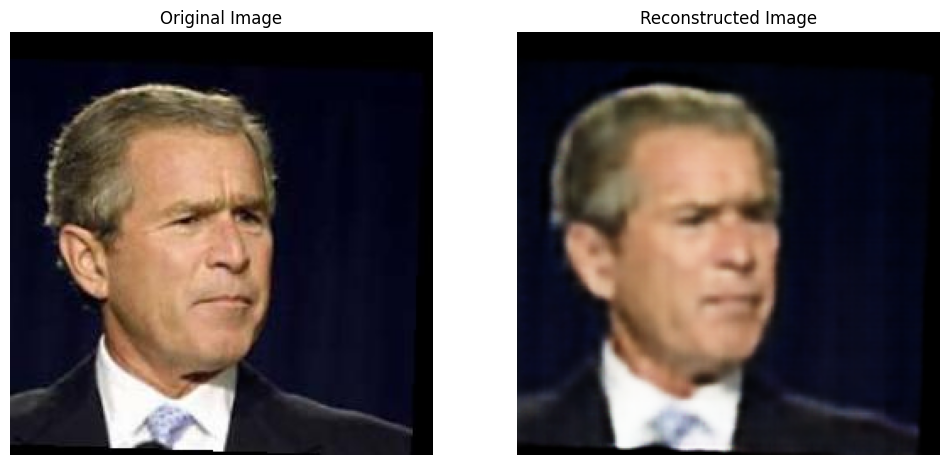

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_img_pil)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img_pil)
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

In [40]:
with torch.no_grad():
    reconstructed_img_noisy = model(input_img, add_noise=True, noise_factor=0.5)

In [41]:
original_img_pil = transform_to_pil(original_img.cpu())
reconstructed_img_pil = transform_to_pil(reconstructed_img.squeeze(0).cpu())
reconstructed_img_noisy_pil = transform_to_pil(reconstructed_img_noisy.squeeze(0).cpu())

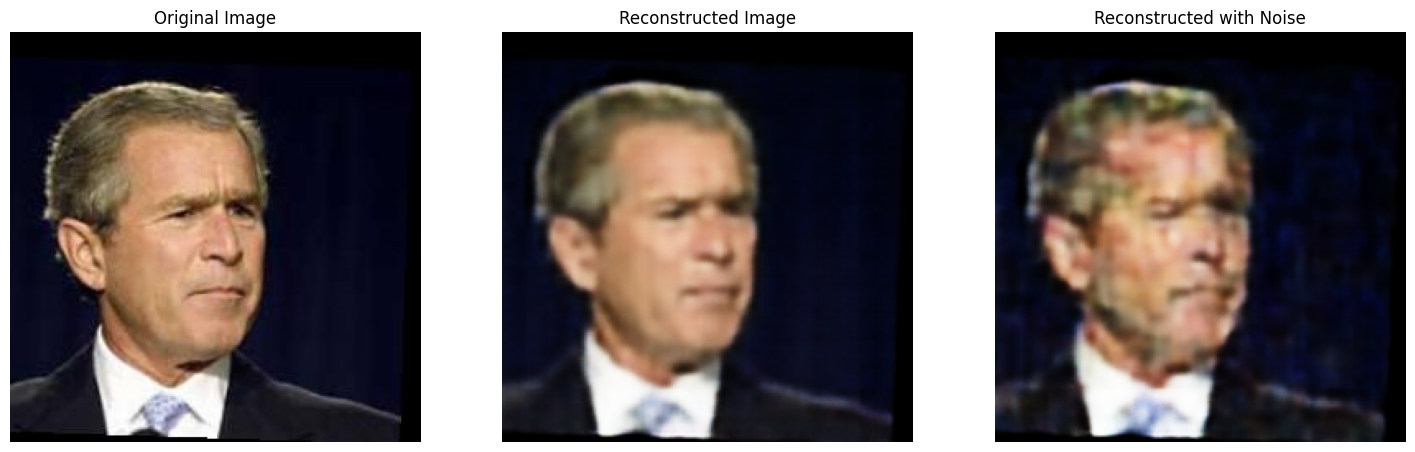

In [42]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(original_img_pil)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_img_pil)
plt.title('Reconstructed Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_img_noisy_pil)
plt.title('Reconstructed with Noise')
plt.axis('off')

plt.show()

Introducing noise into the image results in observable distortions. As the magnitude of the noise factor is elevated, the level of distortion correspondingly intensifies. This process not only alters the clarity of the image but also introduces color variations that were not present in the original depiction.